In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

from sklearn.cluster import KMeans

import random
from sklearn.externals import joblib


In [2]:
stack = 'MD585'
dm = DataManager(stack=stack)

In [3]:
xmin, ymin, w, h = detect_bbox_lookup[stack]
xmin = xmin * 32
ymin = ymin * 32
w = w * 32
h = h * 32
xmax = xmin + w - 1
ymax = ymin + h - 1

In [18]:
output_dir = '/oasis/projects/nsf/csd395/yuncong/Brain/learning/sift'
M = 200 # vocabulary size
colors = np.vstack([(0,0,0), np.random.randint(0, 255, (M, 3))])

In [8]:
# Load vocabulary (as a sklearn.KMeans object)

if os.path.exists(output_dir + '/vocab.pkl'):
    
    # Load vocabulary
    vocabulary = joblib.load(output_dir + '/vocab.pkl')
    
else:
    
    if os.path.exists(output_dir + '/sift_descriptors_pool_arr.bp'):
        
        # Load descriptor pool
        descriptors_pool_arr = bp.unpack_ndarray_file(output_dir + '/sift_descriptors_pool_arr.bp')

        t = time.time()

        vocabulary = KMeans(init='random', n_clusters=M, n_init=10)
        vocabulary.fit(descriptors_pool_arr)

        sys.stderr.write('sift: %.2f seconds\n' % (time.time() - t)) # 300 seconds

        cluster_centers = vocabulary.cluster_centers_

        joblib.dump(vocabulary, output_dir + '/vocab.pkl')

    else:
        
        # Generate SIFT descriptor pool
        descriptors_pool = []

        sift = cv2.SIFT();
        
        for sec in range(first_detect_sec, last_detect_sec+1, 10):

            print sec

            dm.set_slice(sec)
            dm._load_image(versions=['rgb-jpg'])
            img = dm.image_rgb_jpg[ymin:ymax+1, xmin:xmax+1]

            keypoints, descriptors = sift.detectAndCompute(img, None)

            n = 1000
            random_indices = np.random.choice(range(len(descriptors)), n, replace=False)

            descriptors_pool.append(descriptors[random_indices])

        descriptors_pool_arr = np.vstack(descriptors_pool)
        print len(descriptors_pool_arr), 'in descriptor pool'

        bp.pack_ndarray_file(descriptors_pool_arr, output_dir + '/sift_descriptors_pool_arr.bp')

In [9]:
# Compute keypoints and assign labels

sift = cv2.SIFT();

first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]

# for sec in range(first_detect_sec, last_detect_sec+1):
for sec in [first_detect_sec]:
    
    dm.set_slice(sec)
    dm._load_image(versions=['rgb-jpg'])
    
    img = dm.image_rgb_jpg[ymin:ymax+1, xmin:xmax+1]
    
    t = time.time()
    keypoints, descriptors = sift.detectAndCompute(img, None); # 128 dim descriptor ～ 120 seconds
    sys.stderr.write('sift: %.2f seconds\n' % (time.time() - t)) 
    
    keypoints_arr = np.array([k.pt for k in keypoints])
    print len(keypoints), 'keypoints' # ~ 500k
    
    t = time.time()
    keypoint_labels = vocabulary.predict(descriptors)
    sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t))  # ~ 20 s

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (185917440 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
sift: 85.08 seconds


489439 keypoints


predict: 18.70 seconds


In [16]:
# visualize keypoints (color indicating label)

viz = img.copy()
for (x, y), l in zip(keypoints_arr, keypoint_labels):
    cv2.circle(viz, (int(x), int(y)), 3, colors[l], -1)
display_image(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/learning/tmp.jpg

In [12]:
# generate labelmap

labelmap = np.zeros(dm.image_rgb_jpg.shape[:2], np.int)
keypoints_arr_int = np.floor(keypoints_arr + (xmin, ymin)).astype(np.int)
labelmap[keypoints_arr_int[:,1], keypoints_arr_int[:,0]] = keypoint_labels + 1

np.save(output_dir + '/%(stack)s_labelmap.npy' % {'stack': stack}, labelmap)

In [ ]:
# load labelmap

labelmap = np.load(output_dir + '/%(stack)s_labelmap.npy' % {'stack': stack})

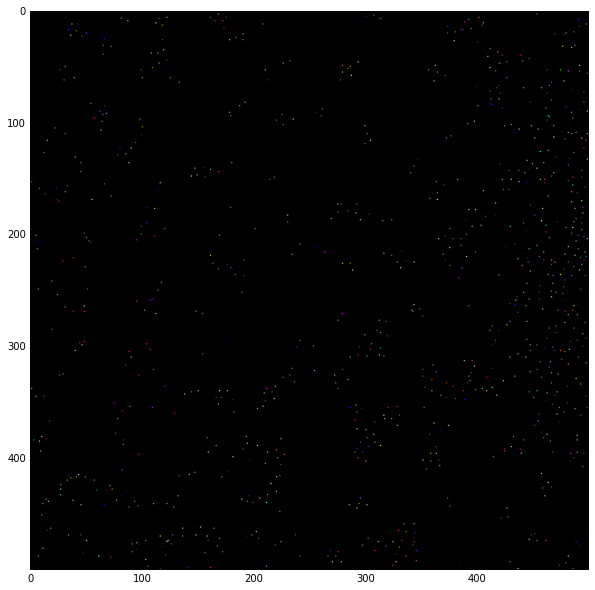

In [25]:
labelmap_viz = colors[labelmap]
# display_image(labelmap_viz[5000:5500, 5000:5500])

plt.figure(figsize=(10,10));
plt.imshow(labelmap_viz[5000:5500, 5000:5500]);
plt.show();

In [26]:
# Load sample locations

patches_rootdir = '/home/yuncong/CSHL_data_patches/'

import pandas as pd

table_filepath = os.path.join(patches_rootdir, '%(stack)s_indices_allROIs_allSections.h5'%{'stack':stack})
indices_allROIs_allSections = pd.read_hdf(table_filepath, 'indices_allROIs_allSections')
grid_parameters = pd.read_hdf(table_filepath, 'grid_parameters')

patch_size, stride, w, h = grid_parameters.tolist()
half_size = patch_size/2
ys, xs = np.meshgrid(np.arange(half_size, h-half_size, stride), np.arange(half_size, w-half_size, stride),
                 indexing='xy')
sample_locations = np.c_[xs.flat, ys.flat]

first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]
sec = first_detect_sec
indices_roi = indices_allROIs_allSections[sec]['roi1']

In [ ]:
# Compute histograms (method 1, slow)

def f(x,y):
    return np.bincount(labelmap[y-half_size:y+half_size-1, x-half_size:x+half_size-1].flat, minlength=M+1)[1:]

t = time.time()
sample_hists_list = []

for s in range(0, len(indices_roi), 100):
    res = Parallel(n_jobs=16)(delayed(f)(x,y) for x, y in sample_locations[indices_roi][s:s+100])
    sample_hists_list.append(res)

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # ~ 72 seconds

from itertools import chain
sample_hists = list(chain(*sample_hists_list))

In [27]:
# Compute histograms (method 2, fast), level-0

sample_locs_roi = sample_locations[indices_roi]
patch_xmin = sample_locs_roi[:,0] - half_size
patch_ymin = sample_locs_roi[:,1] - half_size
patch_xmax = sample_locs_roi[:,0] + half_size
patch_ymax = sample_locs_roi[:,1] + half_size

def compute_histogram_particular_label(i):
    '''
    Compute the histogram of label i using integral image.
    '''
    m = (labelmap == i).astype(np.uint8)
    mi = cv2.integral(m)
    ci = mi[patch_ymin, patch_xmin] + mi[patch_ymax, patch_xmax] - mi[patch_ymax, patch_xmin] - mi[patch_ymin, patch_xmax]
    return ci

t = time.time()
hists = Parallel(n_jobs=16)(delayed(compute_histogram_particular_label)(i) for i in range(1, M+1))
sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # ~ 18 seconds

hists_arr = np.array(hists).T
print hists_arr.shape

In [32]:
# Compute histograms (method 2), for all levels

sample_locs_roi = sample_locations[indices_roi]

# compute level-2 histograms
l = 2

grid_size = patch_size / 2**l

if l == 2:
    rx = [-2, -1, 0, 1]
    ry = [-2, -1, 0, 1]
elif l == 1:
    rx = [-1, 0]
    ry = [-1, 0]
elif l == 0:
    rx = [-.5]
    ry = [-.5]

rxs, rys = np.meshgrid(rx, ry)

patch_coords_allGrid = []

for grid_i, (rx, ry) in enumerate(np.c_[rxs.flat, rys.flat]):
    
    patch_xmin = sample_locs_roi[:,0] + rx * grid_size
    patch_ymin = sample_locs_roi[:,1] + ry * grid_size
    patch_xmax = sample_locs_roi[:,0] + (rx + 1) * grid_size
    patch_ymax = sample_locs_roi[:,1] + (ry + 1) * grid_size
    
    patch_coords_allGrid.append([patch_xmin, patch_ymin, patch_xmax, patch_ymax])

In [34]:
all_coords = np.hstack(patch_coords_allGrid)
patch_xmin = all_coords[0]
patch_ymin = all_coords[1]
patch_xmax = all_coords[2]
patch_ymax = all_coords[3]

In [43]:
def compute_histogram_particular_label(i):
    m = (labelmap == i).astype(np.uint8)
    mi = cv2.integral(m)
    ci = mi[patch_ymin, patch_xmin] + mi[patch_ymax, patch_xmax] - mi[patch_ymax, patch_xmin] - mi[patch_ymin, patch_xmax]
    return ci

In [37]:
t = time.time()
hists = Parallel(n_jobs=16)(delayed(compute_histogram_particular_label)(i) for i in range(1, M+1))
sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # ~ 18 seconds

n_grid = (2**l)**2
hists_arr2 = np.transpose(np.reshape(hists, (M, n_grid, -1)))
print hists_arr2.shape

done in 18.216901 seconds


In [41]:
# compute level-1 histograms based on level-2 histograms

hists_arr1 = np.transpose([hists_arr2[:, [0,1,4,5], :].sum(axis=1),
                           hists_arr2[:, [2,3,6,7], :].sum(axis=1),
                           hists_arr2[:, [8,9,12,13], :].sum(axis=1),
                           hists_arr2[:, [10,11,14,15], :].sum(axis=1)], 
                          [1,0,2])
print hists_arr1.shape

# compute level-0 histograms based on level-1 histograms

hists_arr0 = hists_arr1.sum(axis=1)
print hists_arr0.shape

(20979, 4, 200)
